### **1. Import Libraries**

In [1]:
from IPython.display import clear_output
clear_output()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import os

### **2. Load & Cleaning Data**

In [1]:
# load dataset
df = pd.read_excel('RTW DATA.xlsx')


def clean_data(df):
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    # Filter rows based on column: 'LNCStatus'
    df = df[df['LNCStatus'] != "DRAFT"]

    # Derive column 'isNC' from column: 'LNCNo'
    # check if LNCNo is null, empty, or "null" (case insensitive)
    def isNC(LNCNo):
        if pd.isnull(LNCNo) or str(LNCNo).strip() == "" or str(LNCNo).strip().lower() == "null":
            return 0
        # if not return as 1 or NC
        return 1
    df["isNC"] = df["LNCNo"].apply(isNC)

    # Replace gaps forward from the previous valid value in: 'TimeStop'
    df = df.fillna({'TimeStop': df['TimeStop'].ffill()})

    # Replace missing values with the most common value of each column in: 'Product'
    df = df.fillna({'Product': df['Product'].mode()[0]})

    # Replace missing values with "unknown" in column: 'LNCNo'
    df = df.fillna({'LNCNo': "unknown"})

    # Replace missing values with 0 in column: 'Plant'
    df = df.fillna({'Plant': 0})

    # Replace missing values with "unknown" in column: 'Department'
    df = df.fillna({'Department': "unknown"})

    # Replace missing values with "unknown" in column: 'WorkCenter'
    df = df.fillna({'WorkCenter': "unknown"})

    # Replace missing values with "unknown" in columns: 'FGCode', 'LotNo', 'ProductionDate'
    df = df.fillna({'FGCode': "unknown", 'LotNo': "unknown", 'ProductionDate': "unknown"})

    # Replace missing values with 0 in column: 'Shift'
    df = df.fillna({'Shift': 0})

    # Replace missing values with 0 in column: 'QtyOutput3'
    df = df.fillna({'QtyOutput3': 0})

    # Replace missing values with "unknown" in column: 'LeaderName'
    df = df.fillna({'LeaderName': "unknown"})

    # Drop columns: 'DraftDate', 'RejectReason' and 3 other columns
    df = df.drop(columns=['DraftDate', 'RejectReason', 'ProcessAssy', 'EquipmentID', 'FormInput'])

    # Change column type to string for columns: 'CreateUser', 'ApproveBy' and 2 other columns
    df = df.astype({'CreateUser': 'string', 'ApproveBy': 'string', 'Shift': 'string', 'Plant': 'string'})

    # Membuat kolom-kolom dengan tipe data yang konsisten
    df['SessionID2'] = df['SessionID2'].apply(lambda x: str(x) if pd.notna(x) else "unknown")
    df['LNCStatus'] = df['LNCStatus'].apply(lambda x: str(x) if pd.notna(x) else "unknown")
    df['ApproveBy'] = df['ApproveBy'].fillna("unknown")
    df['CreateUser'] = df['CreateUser'].fillna("unknown")

    # Pastikan kolom tanggal sudah benar-benar dalam format datetime
    df['ApproveDate'] = pd.to_datetime(df['ApproveDate'], errors='coerce')
    df['CreateDate'] = pd.to_datetime(df['CreateDate'], errors='coerce')
    df['TimeStart'] = pd.to_datetime(df['TimeStart'], errors='coerce')
    df['TimeStop'] = pd.to_datetime(df['TimeStop'], errors='coerce')
    df['ProductionDate'] = pd.to_datetime(df['ProductionDate'], errors='coerce')

    # Ganti nilai NaT (Not a Time) dengan nilai default, misalnya tanggal minimum atau "unknown"
    df['ApproveDate'] = df['ApproveDate'].fillna(pd.Timestamp.min)
    df['CreateDate'] = df['CreateDate'].fillna(pd.Timestamp.min)
    df['TimeStart'] = df['TimeStart'].fillna(pd.Timestamp.min)
    df['TimeStop'] = df['TimeStop'].fillna(pd.Timestamp.min)
    df['ProductionDate'] = df['ProductionDate'].fillna(pd.Timestamp.min)

    return df

df_clean = clean_data(df)
df_clean.head()

IndentationError: expected an indented block after function definition on line 12 (684324838.py, line 13)

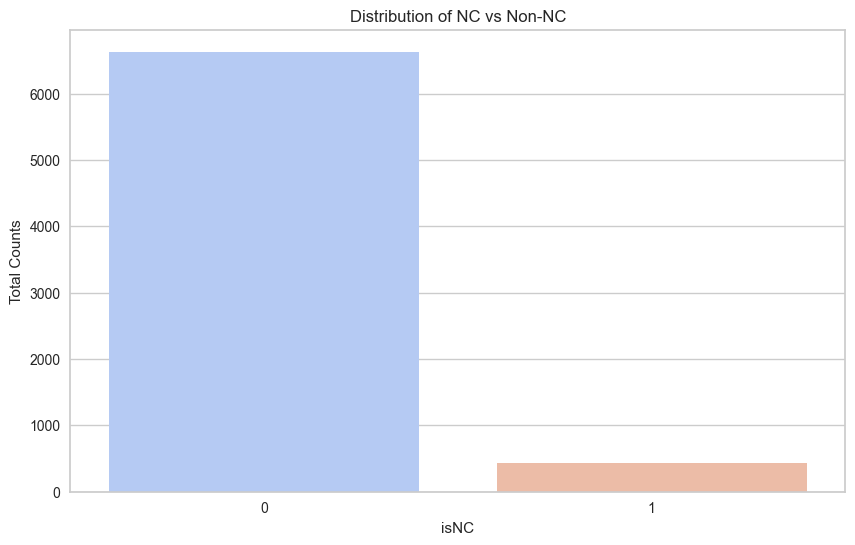

In [3]:
# Plot the distribution of 'isNC' column
plt.figure(figsize=(10,6))
sns.countplot(x='isNC', data=df_clean, palette='coolwarm')
plt.title('Distribution of NC vs Non-NC')
plt.xlabel('isNC')
plt.ylabel('Total Counts')
plt.show()

#### **2.1. Random Over Sampling Target**

In [4]:
# split data into feature and target
X = df_clean.drop(columns=['isNC'])
y = df_clean['isNC']


# apply random oversampling to handle imbalance
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X,y)

In [5]:
# Combine back into a single DataFrame
data_ros = pd.DataFrame(X_ros, columns=X.columns)
data_ros['isNC'] = y_ros

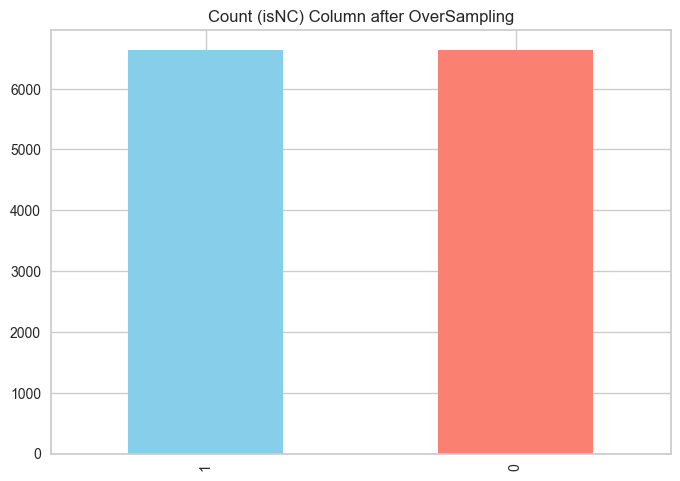

In [6]:
pd.Series(y_ros).value_counts().plot(kind='bar', title='Count (isNC) Column after OverSampling', color=['skyblue', 'salmon'])
plt.show()

### **3. Handling Outliers**

In [7]:
from scipy import stats

# using IQR to remove outliers

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
    
numeric_columns = data_ros.select_dtypes(include=['int64', 'float64']).columns

# remove outliers from dataframe
data_ros_clean = remove_outliers(data_ros, numeric_columns)

# Check rows data before and after outlier removcl
print("Jumlah data sebelum:", len(data_ros))
print("Jumlah data sesudah:", len(data_ros_clean))

Jumlah data sebelum: 13266
Jumlah data sesudah: 12216


### **4. Setup & Training Model**

In [8]:
# Set up PyCaret environment with Random Oversampled data
clf = setup(
    data=data_ros_clean,
    target='isNC',
    session_id=42,
    normalize=True,
)

,Description,Value
0,Session id,42
1,Target,isNC
2,Target type,Binary
3,Original data shape,"(12216, 31)"
4,Transformed data shape,"(12216, 161)"
5,Transformed train set shape,"(8551, 161)"
6,Transformed test set shape,"(3665, 161)"
7,Numeric features,3
8,Date features,5
9,Categorical features,22


In [9]:
# see the best result model
models = compare_models(sort='F1', cross_validation=True, n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.8180
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4990
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1720
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1630
svm,SVM - Linear Kernel,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1650
ridge,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1690
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2300
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1950
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3480
lda,Linear Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3070


In [10]:
# create model
lr_model = create_model('lr', return_train_score=True)

# access the scroing grid
lr_result = pull()
print(lr_result)


               Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
Split    Fold                                               
CV-Train 0          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         1          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         2          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         3          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         4          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         5          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         6          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         7          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         8          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         9          1.0  1.0     1.0    1.0  1.0    1.0  1.0
CV-Val   0          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         1          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         2          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         3          1.0  1.0     1.0    1.0  1.0    1.0  1.0
         4          1.0 

### **5. Finalize Model**

In [11]:
from pycaret.classification import finalize_model
final_model = finalize_model(lr_model)

In [12]:
# Save model
save_model(final_model, 'Logistic_Regression_Model_RTW')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None,
                                     include=['TimeStart', 'TimeStop',
                                              'ProductionDate', 'ApproveDate',
                                              'CreateDate'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Mpw', 'QtyOutput', 'QtyOutput3'],
                                     trans...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=StandardScaler(copy=True,
                    